In [41]:
import cv2
import numpy as np
import urllib.request
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model



In [42]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [44]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


In [45]:
# Convert datasets to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Compute mean and std of training data
mean = np.mean(X_train)
std = np.std(X_train)

# Epsilon to avoid division by zero
epsilon = 1e-7

# Normalize datasets
X_train = (X_train - mean) / (std + epsilon)
X_test = (X_test - mean) / (std + epsilon)
X_valid = (X_valid - mean) / (std + epsilon)


In [46]:
# Convert labels to one-hot encoding for training, validation, and test sets.
# One-hot encoding transforms integer labels into binary vectors.
# 10 indicates the number of classes.
y_train = to_categorical(y_train, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)
y_test  = to_categorical(y_test, num_classes=10)


In [47]:
# Enhanced data augmentation
data_generator = ImageDataGenerator(
    rotation_range=15,  # Rotate images up to 15 degrees to increase rotational invariance.
    width_shift_range=0.1,  # Allow up to 10% horizontal shift. Reduced from 0.12 for subtlety.
    height_shift_range=0.1,  # Allow up to 10% vertical shift, promoting vertical invariance.
    horizontal_flip=True,  # Enable horizontal flip, useful for asymmetric object recognition.
    zoom_range=0.2,  # Increased zoom range to 20% for better scale invariance.
    brightness_range=[0.8, 1.2],  # Widen brightness variation for better illumination invariance.
    shear_range=15,  # Increased shear intensity for enhanced geometric transformation handling.
    channel_shift_range=0.2  # Increased channel shift for improved color invariance.
)


In [48]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

In [49]:
# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())


In [50]:
# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())


In [51]:
# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

In [52]:
# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

In [53]:
# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

In [54]:
# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())


In [55]:
# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

In [58]:
# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [60]:
# Training parameters
batch_size = 64
epochs = 200
initial_lr = 0.0001

# Optimizer configuration
optimizer = Adam(learning_rate=initial_lr)

# Model compilation
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=1)

# Callback for early stopping to prevent overfitting, restoring best model weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Model fitting with training and validation data, applying callbacks for optimized learning
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)


Epoch 1/200
704/704 [==============================] - 442s 527ms/step - loss: 1.5699 - accuracy: 0.4746 - val_loss: 1.3484 - val_accuracy: 0.5272 - lr: 1.0000e-04
Epoch 2/200
704/704 [==============================] - 359s 510ms/step - loss: 1.4834 - accuracy: 0.4994 - val_loss: 1.3430 - val_accuracy: 0.5340 - lr: 1.0000e-04
Epoch 3/200
704/704 [==============================] - 364s 517ms/step - loss: 1.4090 - accuracy: 0.5191 - val_loss: 1.2887 - val_accuracy: 0.5536 - lr: 1.0000e-04
Epoch 4/200
704/704 [==============================] - 380s 540ms/step - loss: 1.3614 - accuracy: 0.5377 - val_loss: 1.3517 - val_accuracy: 0.5464 - lr: 1.0000e-04
Epoch 5/200
704/704 [==============================] - 378s 537ms/step - loss: 1.3113 - accuracy: 0.5485 - val_loss: 1.2372 - val_accuracy: 0.5796 - lr: 1.0000e-04
Epoch 6/200
704/704 [==============================] - 360s 511ms/step - loss: 1.2751 - accuracy: 0.5640 - val_loss: 1.2103 - val_accuracy: 0.5856 - lr: 1.0000e-04
Epoch 7/200
704/

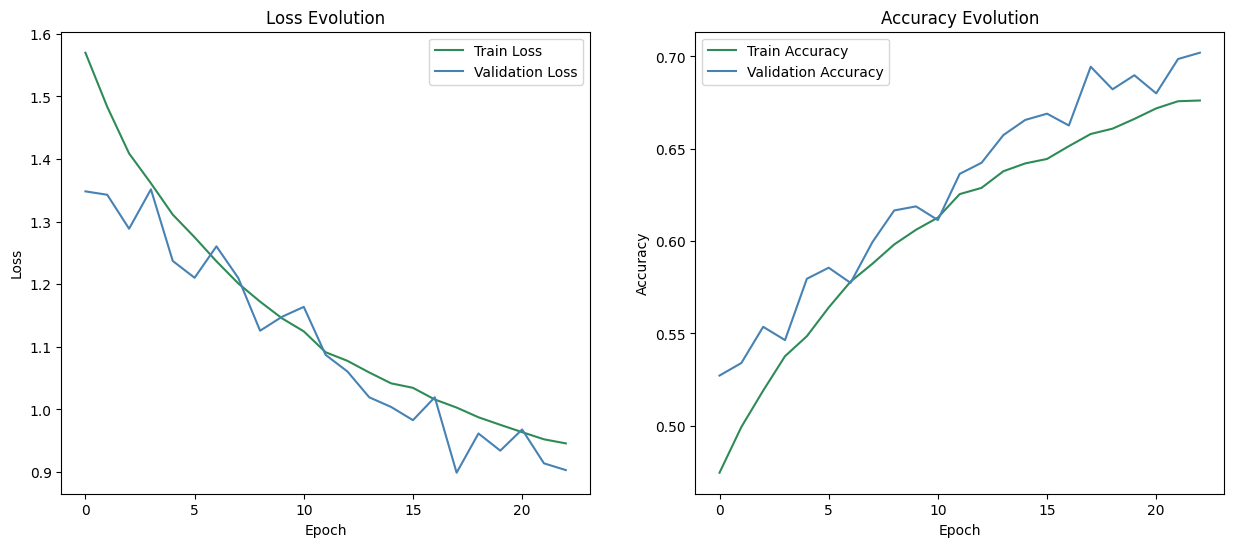

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss with new colors
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='seagreen')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='steelblue')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy with new colors
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='seagreen')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='steelblue')
plt.title('Accuracy Evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [62]:
# Evaluate the model on the test data and print the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)  # Change verbose to 0 for a cleaner output

# Formatting the output for better readability
print(f'\nTest Accuracy: {test_acc:.4f}')  # Formatting to four decimal places
print(f'Test Loss:     {test_loss:.4f}')



Test Accuracy: 0.6919
Test Loss:     0.9062


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Generate predictions
y_pred_prob = model.predict(X_test)
# Convert predictions and true labels from one-hot encoding to class integers
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print the additional metrics
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-score:  {f1:.4f}')

313/313 [==============================] - 23s 73ms/step
Accuracy:  0.6919
Precision: 0.7166
Recall:    0.6919
F1-score:  0.6829


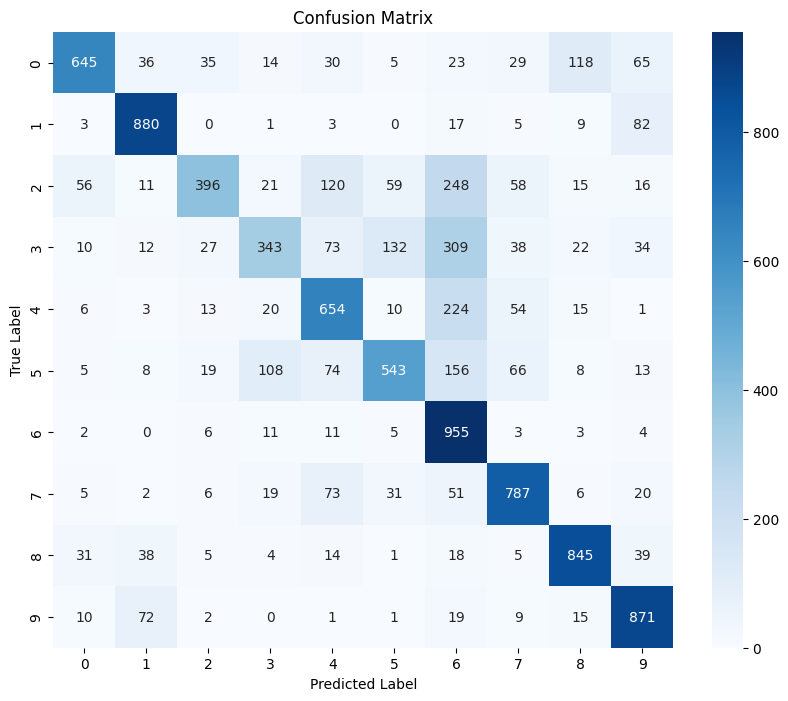

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Performance Metrics Interpretation

The model shows promising results with a 69% accuracy and precision above 71%, indicating reliable classification for a complex dataset. However, the slightly lower F1-score at 68.29% suggests room for improvement in consistently identifying all class labels accurately.

Challenges Encountered

Challenges faced included class imbalance, potentially skewing performance towards well-represented classes, and overfitting, where the model learns training data too closely, affecting its generalizability. The model's complexity and the need for precise hyperparameter tuning also presented hurdles, balancing the need to capture sufficient detail without overcomplicating the model or making it too simple.

Misclassifications Analysis

Misclassifications may arise from intrinsic similarities among classes. Limited representation of certain classes or examples in the training set can diminish performance for those groups. Furthermore, variations in object placement, background noise, and image quality contribute to classification errors.

Conclusion and Recommendations

The CNN model shows promise in image classification, achieving 70% accuracy, yet improvements are needed due to misclassifications and precision-F1 discrepancies.

Recommendations include enhancing data augmentation, ensuring class balance, adjusting model complexity, applying regularization, optimizing hyperparameters, and considering transfer learning for performance boosts.